In [35]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
import pandas as pd
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at all dsets

In [44]:
ddir = 'iaip_data/Datasets'
fnames = sorted([fname for fname in os.listdir(ddir) 
                 if 'csv' in fname
                 and not 'formats' in fname
                 and not 'form6' in fname]) # remove outcome
feature_names = [fname[:-4].replace('form', '').replace('-', '_') for fname in fnames]
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv')
# print(fnames)

In [45]:
r = {}
for fname in tqdm(fnames):
    df = pd.read_csv(oj(ddir, fname), engine='python')
    df.rename(columns={'SubjectID': 'id'}, inplace=True)
    df.rename(columns={'subjectid': 'id'}, inplace=True)
    assert('id' in df.keys())
    r[fname] = df

100%|██████████| 49/49 [00:01<00:00, 34.56it/s]


In [46]:
missing_arr = np.zeros((len(fnames), NUM_PATIENTS + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
    df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

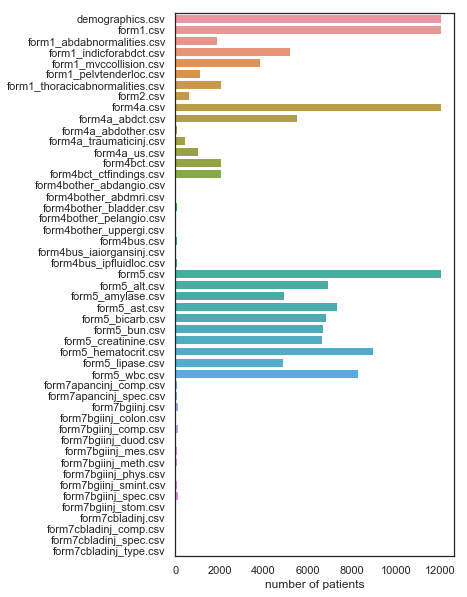

In [5]:
plt.figure(figsize=(5, 10))
sns.barplot(x=missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients')
plt.savefig('num_patients.png')
plt.show()

<Figure size 3600x6000 with 0 Axes>

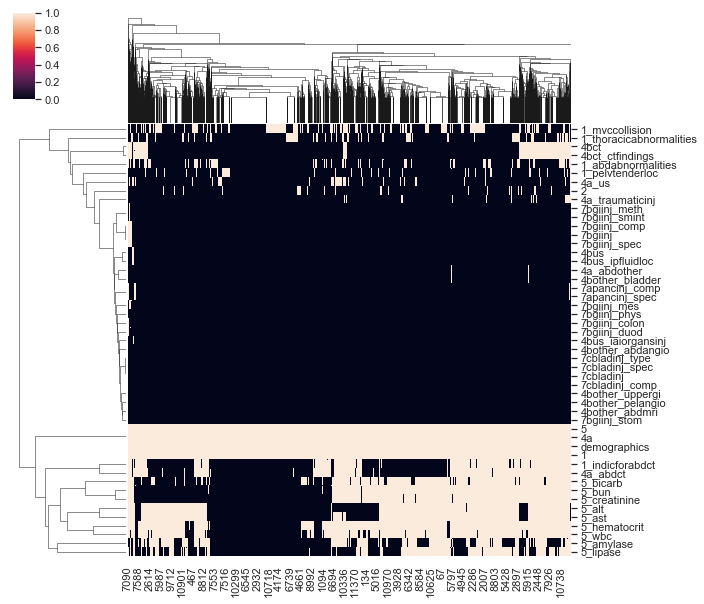

In [7]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=feature_names)
# plt.tight_layout()
# plt.savefig('missing.png')
plt.show()

# make features 

**merge everything**

In [52]:
df = r[fnames[0]]
how = 'outer'
print(len(fnames))
for i, fname in tqdm(enumerate(fnames[1:3])): # this should include more than 3!
    df2 = r[fname].copy()
    rename_dict = {
        key: key + '_' + feature_names[i + 1][:8] 
        for key in df2.keys()
        if not key == 'id'
    }
    df2.rename(columns=rename_dict, inplace=True)
    df = pd.merge(df, df2, on='id', how=how)
df.to_pickle('features.pkl')

2it [00:00, 22.73it/s]

49


**code features**

In [161]:
# for k in ['RACE', 'SEX']:
#     df[k] = df[k].astype(str)
for k in ['ageinyrs']:
    df[k] = df[k].astype(float)

In [ ]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

In [176]:
df.keys()

Index(['id', 'repeat_instance', 'BladInjType', 'BladExLac', 'BladExLacLoc',
       'BladIntLac'],
      dtype='object')

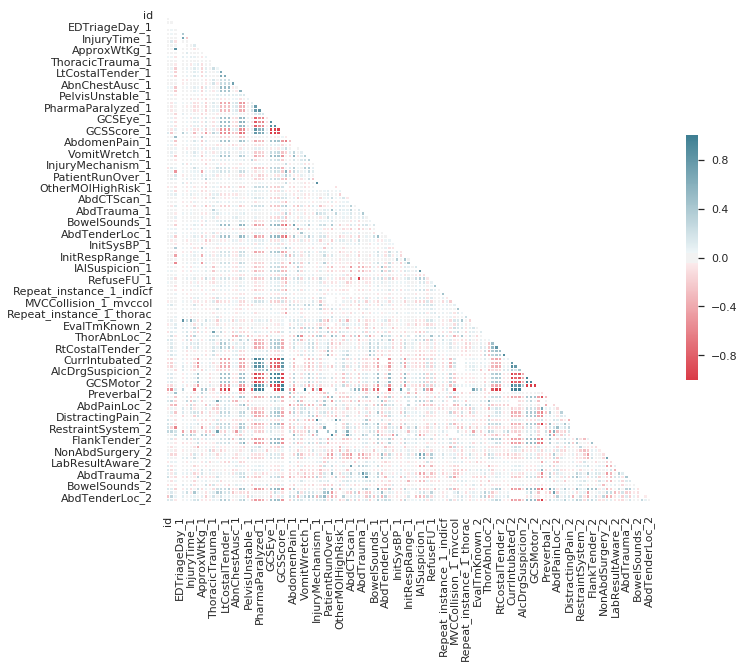

In [170]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# outcome

- want to get iai (has 761 positives)
- and iai + intervention (has 203 positives)

In [63]:
outcomes = pd.read_csv('iaip_data/Datasets/form6a.csv').rename(columns={'subjectid': 'id'})
outcomes_full_pi = pd.read_csv('iaip_data/Datasets/form6b.csv').rename(columns={'SubjectID': 'id'}) 
outcomes_full_surg = pd.read_csv('iaip_data/Datasets/form6c.csv').rename(columns={'subjectid': 'id'})

# (6b) Intra-abdominal injury diagnosed in the ED/during hospitalization by any diagnostic method
# 1 is yes, 761 have intra-abdominal injury
# 2 is no -> remap to 0, 841 without intra-abdominal injury
idxs_iai = outcomes_full_pi.id[outcomes_full_pi['IAIinED1'] == 1]
iai = np.zeros(NUM_PATIENTS).astype(np.int)
iai[idxs_iai] = 1
df_iai = pd.DataFrame.from_dict({
    'id': np.arange(1, NUM_PATIENTS + 1),
    'iai': iai
})


In [34]:
num = 0
for key in ['DidPtDie', 'Laparoscopy']: # 'NonAbdSurg', 'PelvicFracture']:
    print(key, np.sum(outcomes[key] == 1))
    num += np.sum(outcomes[key] == 1)
print(num)

DidPtDie 100
Laparoscopy 18
118


In [33]:
np.sum(outcomes['DidPtDie'] == 1)

100

# correlations with outcome

In [48]:
iai

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
df.keys()

Index(['id', 'SEX', 'RACE', 'OTHER_RACE', 'HISPANIC_ETHNICITY', 'ageinyrs',
       'EDTriageDay_1', 'EDTriageTime_1', 'InjuryDay_1', 'InjuryTime_1',
       'InjTmKnown_1', 'TriageTmUnkown_1', 'ApproxWtKg_1', 'WtAssessment_1',
       'Certification_1', 'ThoracicTrauma_1', 'ThorAbnLoc_1',
       'ThoracicTender_1', 'LtCostalTender_1', 'RtCostalTender_1',
       'DecrBreathSound_1', 'AbnChestAusc_1', 'FlankTender_1',
       'PelvicTender_1', 'PelvisUnstable_1', 'NonAbdSurgery_1',
       'CurrIntubated_1', 'PharmaParalyzed_1', 'PharmaSedated_1',
       'AlcDrgSuspicion_1', 'GCSEye_1', 'GCSVerbal_1', 'GCSMotor_1',
       'GCSScore_1', 'AggregateGCS_1', 'Preverbal_1', 'AbdomenPain_1',
       'AbdPainSeverity_1', 'AbdPainLoc_1', 'VomitWretch_1', 'ShortBreath_1',
       'DistractingPain_1', 'InjuryMechanism_1', 'InjMechSpecs_1',
       'PatientRestrained_1', 'RestraintSystem_1', 'PatientRunOver_1',
       'HandlebarsAbd_1', 'OtherMechanism_1', 'GenComment_1', 'RecodedMOI_1',
       'OtherMOIHi

In [72]:
X = pd.merge(df[['id', 'SEX', 'RACE', 'ageinyrs', 'GCSScore_1']], df_iai, on='id', how='inner')

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize)

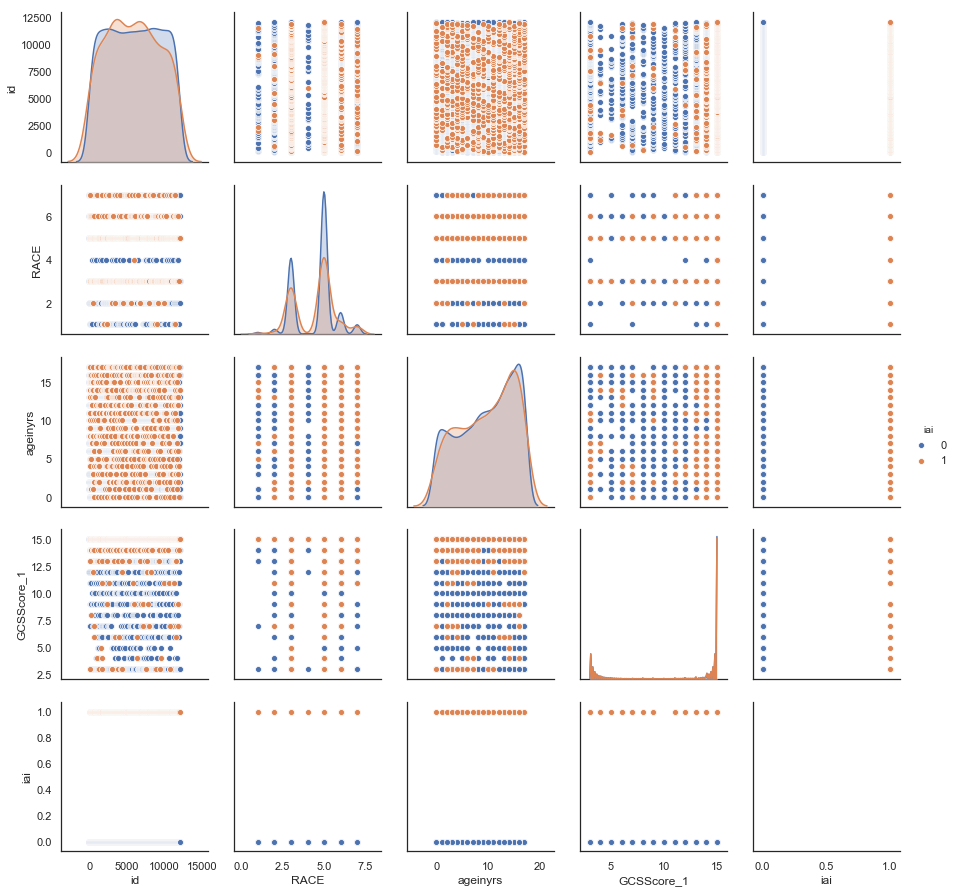

In [73]:
sns.pairplot(X, hue='iai')
plt.show()